> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, estimate the parameters.

> We select the last 32 time steps of a 32 x 32 grid of a solution of ASDM. The Training dataset includes all grid's data point.

> The free parameters of the model are fixed.

> The goal here is overfitting the model to re-create the exact output from the mtrained model. Therefore, we can be sure about the code and the selected architecture.

In [1]:
%config Completer.use_jedi = False

In [2]:
import sys
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import time
import threading

GPU = False
import os

if GPU:
    txt_device = 'gpu:0'
else:
    txt_device = 'cpu:0'    
    os.environ["CUDA_VISIBLE_DEVICES"]="-1"


In [3]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, 
                 model_name,                 
                 x_obs, y_obs, t_obs, a_obs, s_obs, 
                 x_pde, y_pde, t_pde,
                 layers,
                 x_boundary_LB = None, y_boundary_LB = None, t_boundary_LB= None, 
                 x_boundary_TR= None, y_boundary_TR= None, t_boundary_TR= None,
                 model_params={},
                 storage_dir='./'): 
        
        self.model_name = model_name
        self.model_params = model_params
        self.storage_dir = storage_dir
        self.__saver__ = None
        
        if x_boundary_LB is None or \
           x_boundary_TR is None or \
           y_boundary_LB is None or \
           y_boundary_TR is None or \
           t_boundary_LB is None or \
           t_boundary_TR is None:
            self.flg_boundary = False
        else:
            self.flg_boundary = True
        
        
        with tf.device(txt_device):
                 
            X = np.concatenate([x_obs, y_obs, t_obs], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x_obs = X[:,0:1]
            self.y_obs = X[:,1:2]
            self.t_obs = X[:,2:3]

            self.a_obs = a_obs
            self.s_obs = s_obs
            
            X = np.concatenate([x_pde, y_pde, t_pde], 1)
            
            self.x_pde = x_pde
            self.y_pde = y_pde
            self.t_pde = t_pde
            
            self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
            self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
            self.x_pde = X[:,0:1]
            self.y_pde = X[:,1:2]
            self.t_pde = X[:,2:3]
            
            if self.flg_boundary:
                X = np.concatenate([x_boundary_LB, y_boundary_LB, t_boundary_LB], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_LB = X[:,0:1]
                self.y_boundary_LB = X[:,1:2]
                self.t_boundary_LB = X[:,2:3]
            
            
                X = np.concatenate([x_boundary_TR, y_boundary_TR, t_boundary_TR], 1)
            
                self.lb = np.amin(np.c_[X.min(0), self.lb], 1)
                self.ub = np.amax(np.c_[X.max(0), self.ub], 1)
            
                self.x_boundary_TR = X[:,0:1]
                self.y_boundary_TR = X[:,1:2]
                self.t_boundary_TR = X[:,2:3]           

            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_a", 
                                   constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.005, dtype=tf.float32)#
            self.D_s = tf.Variable([1.0], dtype=tf.float32, 
                                   name="D_s",
                                  constraint= lambda z: tf.clip_by_value(z, 1e-6, 1e10))#tf.constant(0.2, dtype=tf.float32)#
            self.sigma_a = tf.Variable([0.0], dtype=tf.float32,
                                      name="sigma_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.0, dtype=tf.float32, name="sigma_a")#
            self.sigma_s = tf.Variable([1.00], dtype=tf.float32, 
                                       name="sigma_s",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.mu_a = tf.Variable([1.00], dtype=tf.float32, 
                                    name="mu_a",
                                   constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_a = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_a",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.01, dtype=tf.float32)#
            self.rho_s = tf.Variable([1.00], dtype=tf.float32, 
                                     name="rho_s",
                                    constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.02, dtype=tf.float32)#
            self.kappa_a = tf.Variable([1.00], dtype=tf.float32,
                                       name="kappa_a",
                                      constraint= lambda z: tf.clip_by_value(z, 0, 1e10))#tf.constant(0.25, dtype=tf.float32)##

        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        self.x_obs_tf = tf.placeholder(tf.float32, shape=[None, self.x_obs.shape[1]], name="x_obs_tf")
        self.y_obs_tf = tf.placeholder(tf.float32, shape=[None, self.y_obs.shape[1]], name="y_obs_tf")
        self.t_obs_tf = tf.placeholder(tf.float32, shape=[None, self.t_obs.shape[1]], name="t_obs_tf")

        self.a_obs_tf = tf.placeholder(tf.float32, shape=[None, self.a_obs.shape[1]], name="a_obs_tf")
        self.s_obs_tf = tf.placeholder(tf.float32, shape=[None, self.s_obs.shape[1]], name="s_obs_tf")
        
        
        self.x_pde_tf = tf.placeholder(tf.float32, shape=[None, self.x_pde.shape[1]], name="x_pde_tf")
        self.y_pde_tf = tf.placeholder(tf.float32, shape=[None, self.y_pde.shape[1]], name="y_pde_tf")
        self.t_pde_tf = tf.placeholder(tf.float32, shape=[None, self.t_pde.shape[1]], name="t_pde_tf")
        
        
        if self.flg_boundary:
            self.x_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_LB.shape[1]], name="x_boundary_LB_tf")
            self.y_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_LB.shape[1]], name="y_boundary_LB_tf")
            self.t_boundary_LB_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_LB.shape[1]], name="t_boundary_LB_tf")
        
            self.x_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.x_boundary_TR.shape[1]], name="x_boundary_TR_tf")
            self.y_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.y_boundary_TR.shape[1]], name="y_boundary_TR_tf")
            self.t_boundary_TR_tf = tf.placeholder(tf.float32, shape=[None, self.t_boundary_TR.shape[1]], name="t_boundary_TR_tf")

        # Observations
        self.a_pred, self.s_pred = self.net_ASDM(self.x_obs_tf, self.y_obs_tf, self.t_obs_tf)
        # PDE's Residuals
        self.a_pde_pred, self.s_pde_pred = self.net_ASDM(self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        self.a_res_pde, self.s_res_pde = self.net_grads(self.a_pde_pred, self.s_pde_pred, self.x_pde_tf, self.y_pde_tf, self.t_pde_tf)
        # Boundary conditions
        if self.flg_boundary:
            self.a_boundary_LB, self.s_boundary_LB = self.net_ASDM(self.x_boundary_LB_tf, self.y_boundary_LB_tf, self.t_boundary_LB_tf)
            self.a_boundary_TR, self.s_boundary_TR = self.net_ASDM(self.x_boundary_TR_tf, self.y_boundary_TR_tf, self.t_boundary_TR_tf)
        
        
        # Losses
        # Observation loss
        self.loss_obs = tf.reduce_sum(tf.square(self.a_obs_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_obs_tf - self.s_pred)) 
        # PDE residuals loss
        self.loss_pde_a = tf.reduce_sum(tf.square(self.a_res_pde), name = "loss_pde_a")
        self.loss_pde_s = tf.reduce_sum(tf.square(self.s_res_pde), name = "loss_pde_s")
        # Boundary condition loss
        if self.flg_boundary:
            self.loss_boundary_a = tf.reduce_sum(tf.square(self.a_boundary_LB - self.a_boundary_TR)
                                                 ,name = "loss_boundary_a")
            self.loss_boundary_s = tf.reduce_sum(tf.square(self.s_boundary_LB - self.s_boundary_TR)
                                                 ,name = "loss_boundary_s")
        

        # Total loss
        self.loss = self.loss_obs + self.loss_pde_a + self.loss_pde_s
        if self.flg_boundary:
            self.loss +=  self.loss_boundary_a + self.loss_boundary_s
        # Optimiser
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):        
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")              
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")                
        
        return a, s
    
    def net_grads(self, a, s, x, y, t):
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - (a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - (s_xx + s_yy) + rho_s*f - sigma_s
        
        return f_a, f_s
        
    
    def callback(self, loss, loss_obs, loss_pde_a, loss_pde_s, 
                 D_a, D_s, sigma_a, sigma_s,
                 rho_a, rho_s, mu_a, kappa_a,
                 loss_boundary_a = None, loss_boundary_s = None):
        print(f"loss: {loss.tolist()}, loss_obs: {loss_obs.tolist()},\n"
              f"loss_a: {loss_pde_a.tolist()}, loss_s: {loss_pde_s.tolist()},\n"
              f"loss_boundary_a: {loss_boundary_a.tolist() if loss_boundary_a is not None else 0}, "
              f"loss_boundary_s: {loss_boundary_s.tolist() if loss_boundary_s is not None else 0},\n"
              f"D_a: {D_a.tolist()}, D_s: {D_s.tolist()}\n"
              f"sigma_a: {sigma_a.tolist()}, sigma_s: {sigma_s.tolist()}\n"
              f"rho_a: {rho_a.tolist()}, rho_s: {rho_s.tolist()}\n"
              f"mu_a: {mu_a.tolist()}, kappa_a: {kappa_a.tolist()}\n")
        
      
    def train_batch(self, nIter, batch_size, early_stop_thresh = None, print_iter = 100):
        
        data_n = self.x_obs.shape[0]
        batch_steps = data_n//batch_size
        batch_steps = batch_steps + (data_n-1)//(batch_steps*batch_size)
        
        pde_n = self.x_pde.shape[0]
        pde_batch_size = pde_n//batch_steps        
        
        if self.flg_boundary:
            boundary_n = self.x_boundary_LB.shape[0]        
            boundary_batch_size = boundary_n//batch_steps
        
        
        data = np.concatenate([self.x_obs, self.y_obs, self.t_obs, self.a_obs, self.s_obs], 1)
        pde = np.concatenate([self.x_pde, self.y_pde, self.t_pde], 1)
        if self.flg_boundary:
            boundary_LB = np.concatenate([self.x_boundary_LB, self.y_boundary_LB, self.t_boundary_LB], 1)
            boundary_TR = np.concatenate([self.x_boundary_TR, self.y_boundary_TR, self.t_boundary_TR], 1)
        
        indices_data = np.array(list(range(data_n)))
        indices_pde = np.array(list(range(pde_n)))
        if self.flg_boundary:
            indices_boundary = np.array(list(range(boundary_n)))
        
        arr_total_loss = np.zeros(nIter)
        arr_total_loss_obs = np.zeros(nIter)
        arr_total_loss_pde_a = np.zeros(nIter)
        arr_total_loss_pde_s = np.zeros(nIter)
        if self.flg_boundary:
            arr_total_loss_boundary_a = np.zeros(nIter)
            arr_total_loss_boundary_s = np.zeros(nIter)
        
        arr_D_a = np.zeros(nIter)
        arr_D_s = np.zeros(nIter)
        arr_sigma_a = np.zeros(nIter)
        arr_sigma_s = np.zeros(nIter)
        arr_rho_a = np.zeros(nIter)
        arr_rho_s = np.zeros(nIter)
        arr_mu_a = np.zeros(nIter)
        arr_kappa_a = np.zeros(nIter)
        
        def _get_val(item):
            val = item.tolist()
            if type(val) is float:
                return val
            else:
                return val[0]
        
        start_time = time.time()
        for it in range(nIter):
            # Shuflle the batches in each epoch
            np.random.shuffle(indices_data)
            np.random.shuffle(indices_pde)
            if self.flg_boundary:
                np.random.shuffle(indices_boundary)
            
            total_loss = 0
            total_loss_obs = 0
            total_loss_pde_a = 0
            total_loss_pde_s = 0
            total_loss_boundary_a = 0
            total_loss_boundary_s = 0
            
            for batch in range(batch_steps):
                data_start = batch*batch_size
                data_end = (batch+1)*batch_size
                data_end = data_end - (data_end//data_n)*(data_end%data_n)
                
                pde_start = batch*pde_batch_size
                pde_end = (batch+1)*pde_batch_size
                #pde_end -= (pde_end//pde_n)*(pde_end%pde_n)                                
                if self.flg_boundary:
                    boundary_start = batch*boundary_batch_size
                    boundary_end = (batch+1)*boundary_batch_size
                #boundary_end -= (boundary_end//boundary_n)*(boundary_end%boundary_n) 
                # Correction for other batch at last step
                if batch == batch_steps-1:
                    if pde_end < pde_n:
                        pde_end = pde_n
                        
                    if self.flg_boundary and boundary_end < boundary_n:
                        boundary_end = boundary_n
                        
                
                #print(f"Batch:{batch}, data:{data_start}-{data_end}, "
                #     f"data:{pde_start}-{pde_end}, "
                #     f"data:{boundary_start}-{boundary_end}")
                
                batch_indices_data = indices_data[data_start:data_end]
                batch_indices_pde = indices_pde[pde_start:pde_end]
                if self.flg_boundary:
                    batch_indices_boundary = indices_boundary[boundary_start:boundary_end]
                
                tf_dict = {self.x_obs_tf: data[batch_indices_data, 0:1], 
                           self.y_obs_tf: data[batch_indices_data, 1:2], 
                           self.t_obs_tf: data[batch_indices_data, 2:3],
                           self.a_obs_tf: data[batch_indices_data, 3:4], 
                           self.s_obs_tf: data[batch_indices_data, 4:5],
                           self.x_pde_tf: pde[batch_indices_pde, 0:1],
                           self.y_pde_tf: pde[batch_indices_pde, 1:2],
                           self.t_pde_tf: pde[batch_indices_pde, 2:3]}
                if self.flg_boundary:
                    tf_dict = {**tf_dict , 
                               **{self.x_boundary_LB_tf: boundary_LB[batch_indices_boundary, 0:1],
                                  self.y_boundary_LB_tf: boundary_LB[batch_indices_boundary, 1:2],
                                  self.t_boundary_LB_tf: boundary_LB[batch_indices_boundary, 2:3],
                                  self.x_boundary_TR_tf: boundary_TR[batch_indices_boundary, 0:1],
                                  self.y_boundary_TR_tf: boundary_TR[batch_indices_boundary, 1:2],
                                  self.t_boundary_TR_tf: boundary_TR[batch_indices_boundary, 2:3]}
                              }
                
                
                self.sess.run(self.train_op_Adam, tf_dict)
            
                loss_value = _get_val(self.sess.run(self.loss, tf_dict))
                loss_obs_value = _get_val(self.sess.run(self.loss_obs, tf_dict))
                loss_pde_a_value = _get_val(self.sess.run(self.loss_pde_a, tf_dict))
                loss_pde_s_value = _get_val(self.sess.run(self.loss_pde_s, tf_dict))
                if self.flg_boundary:
                    loss_boundary_a_value = _get_val(self.sess.run(self.loss_boundary_a, tf_dict))
                    loss_boundary_s_value = _get_val(self.sess.run(self.loss_boundary_s, tf_dict))
                
                total_loss += loss_value
                total_loss_obs += loss_obs_value
                total_loss_pde_a += loss_pde_a_value
                total_loss_pde_s += loss_pde_s_value
                if self.flg_boundary:
                    total_loss_boundary_a += loss_boundary_a_value
                    total_loss_boundary_s += loss_boundary_s_value
                    
            D_a_value = _get_val(self.sess.run(self.D_a))
            D_s_value = _get_val(self.sess.run(self.D_s))             
            sigma_a_value = _get_val(self.sess.run(self.sigma_a))
            sigma_s_value = _get_val(self.sess.run(self.sigma_s))              
            rho_a_value = _get_val(self.sess.run(self.rho_a))
            rho_s_value = _get_val(self.sess.run(self.rho_s))
            mu_a_value = _get_val(self.sess.run(self.mu_a))
            kappa_a_value = _get_val(self.sess.run(self.kappa_a))
            
            arr_total_loss[it] = total_loss
            arr_total_loss_obs[it] = total_loss_obs
            arr_total_loss_pde_a[it] = total_loss_pde_a
            arr_total_loss_pde_s[it] = total_loss_pde_s
            if self.flg_boundary:
                arr_total_loss_boundary_a[it] = total_loss_boundary_a
                arr_total_loss_boundary_s[it] = total_loss_boundary_s
            arr_D_a[it] = D_a_value
            arr_D_s[it] = D_s_value            
            arr_sigma_a[it] = sigma_a_value
            arr_sigma_s[it] = sigma_s_value
            arr_rho_a[it] = rho_a_value
            arr_rho_s[it] = rho_s_value
            arr_mu_a[it] = mu_a_value
            arr_kappa_a[it] = kappa_a_value
            
            # Print
            if it % print_iter == 0:
                elapsed = time.time() - start_time                                                                
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
            # early stop
            if early_stop_thresh is not None and early_stop_thresh >= total_loss:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time                                                                                                    
                print(f"It: {it}, loss:{total_loss:.2f}, loss_obs:{total_loss_obs:.8f}, \n"
                      f"loss_pde_a: {total_loss_pde_a:.8f}, loss_pde_s: {total_loss_pde_s:.8f}, \n"
                      f"loss_boundary_a: {total_loss_boundary_a:.8f}, loss_boundary_s: {total_loss_boundary_s:.8f}, \n"
                      f"D_a: {D_a_value:.8f}, D_s: {D_s_value:.8f}\n"
                      f"sigma_a: {sigma_a_value:.8f}, sigma_s: {sigma_s_value:.8f}\n"
                      f"rho_a: {rho_a_value:.8f}, rho_s: {rho_s_value:.8f}\n"
                      f"mu_a: {mu_a_value:.8f}, kappa_a: {kappa_a_value:.8f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time() 
                
                losses = {'total_loss': arr_total_loss[:(it+1)],
                          'loss_obs': arr_total_loss_obs[:(it+1)],
                          'loss_pde_a': arr_total_loss_pde_a[:(it+1)],
                          'loss_pde_s': arr_total_loss_pde_s[:(it+1)]                          
                          }
                if self.flg_boundary:
                    losses = {**losses, 
                              **{'loss_boundary_a': arr_total_loss_boundary_a[:(it+1)],
                                 'loss_boundary_s': arr_total_loss_boundary_s[:(it+1)]}
                             }
                params = {'D_a': arr_D_a[:(it+1)], 'D_s': arr_D_s[:(it+1)],
                          'sigma_a': arr_sigma_a[:(it+1)] , 'sigma_s': arr_sigma_s[:(it+1)],
                          'rho_a' : arr_rho_a[:(it+1)], 'rho_s' : arr_rho_s[:(it+1)],
                          'mu_a': arr_mu_a[:(it+1)], 'kappa_a': arr_kappa_a[:(it+1)]}
                
                return (losses, params)    
                    
            
        # end for it
        losses = {'total_loss': arr_total_loss,
                  'loss_obs': arr_total_loss_obs,
                  'loss_pde_a': arr_total_loss_pde_a,
                  'loss_pde_s': arr_total_loss_pde_s
                 }
        if self.flg_boundary:
            losses = {**losses, 
                      **{'loss_boundary_a': arr_total_loss_boundary_a,
                         'loss_boundary_s': arr_total_loss_boundary_s}
                    }
        
        params = {'D_a': arr_D_a, 'D_s': arr_D_s,
                  'sigma_a': arr_sigma_a , 'sigma_s': arr_sigma_s,
                  'rho_a' : arr_rho_a, 'rho_s' : arr_rho_s, 'mu_a': arr_mu_a, 'kappa_a': arr_kappa_a}
        
        
        return (losses, params)
                
            
        
        
    def minimise(self, max_iter = None, f_tol = None):
        if max_iter is not None:
            self.optimizer.optimizer_kwargs['options']['maxiter'] = max_iter
            
        if f_tol is not None:
            self.optimizer.optimizer_kwargs['options']['f_tol'] = f_tol
        
        if self.flg_boundary:
            tf_dict = {self.x_obs_tf: self.x_obs, self.y_obs_tf: self.y_obs, self.t_obs_tf: self.t_obs,
                       self.a_obs_tf: self.a_obs, self.s_obs_tf: self.s_obs,
                       self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde,
                       self.x_boundary_LB_tf: self.x_boundary_LB, 
                       self.y_boundary_LB_tf: self.y_boundary_LB, 
                       self.t_boundary_LB_tf: self.t_boundary_LB,
                       self.x_boundary_TR_tf: self.x_boundary_TR, 
                       self.y_boundary_TR_tf: self.y_boundary_TR, 
                       self.t_boundary_TR_tf: self.t_boundary_TR
                      }
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_obs, self.loss_pde_a, self.loss_pde_s,                                           
                                           self.D_a, self.D_s,
                                           self.sigma_a, self.sigma_s,
                                           self.rho_a, self.rho_s,
                                           self.mu_a, self.kappa_a,
                                           self.loss_boundary_a, 
                                           self.loss_boundary_s],
                                loss_callback = self.callback)      
                      
        else:
            tf_dict = {self.x_obs_tf: self.x_obs, self.y_obs_tf: self.y_obs, self.t_obs_tf: self.t_obs,
                   self.a_obs_tf: self.a_obs, self.s_obs_tf: self.s_obs,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
            self.optimizer.minimize(self.sess,
                                feed_dict = tf_dict,
                                fetches = [self.loss, self.loss_obs, self.loss_pde_a, self.loss_pde_s,                                           
                                           self.D_a, self.D_s,
                                           self.sigma_a, self.sigma_s,
                                           self.rho_a, self.rho_s,
                                           self.mu_a, self.kappa_a],
                                loss_callback = self.callback)        
            
            
        
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_obs_tf: x_star, self.y_obs_tf: y_star, self.t_obs_tf: t_star,
                   self.x_pde_tf: self.x_pde, self.y_pde_tf: self.y_pde, self.t_pde_tf: self.t_pde}
        if self.flg_boundary:
            tf_dict = {**tf_dict,
                       **{self.x_boundary_LB_tf: self.x_boundary_LB, 
                          self.y_boundary_LB_tf: self.y_boundary_LB, 
                          self.t_boundary_LB_tf: self.t_boundary_LB,
                          self.x_boundary_TR_tf: self.x_boundary_TR, 
                          self.y_boundary_TR_tf: self.y_boundary_TR, 
                          self.t_boundary_TR_tf: self.t_boundary_TR}
                      }
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star
    
    def __getstate__(self):
        # Save tensorflow graph
        if self.__saver__ is None:
            saver = tf.train.Saver(max_to_keep=1)
        else:
            saver = tf.train.Saver(max_to_keep=1, saver_def=self.__saver__)
           
        import os
        if not os.path.exists(self.storage_dir):
            os.makedirs(self.storage_dir)
            
        saver.save(self.sess, f"{self.storage_dir}{self.model_name}")
        self.__saver__ = saver.as_saver_def()
        # Copy the object's state from self.__dict__ which contains
        # all our instance attributes. Always use the dict.copy()
        # method to avoid modifying the original state.
        state = self.__dict__.copy()
        
        # Remove the unpicklable entries and save the op_name for storage        
        for item in ['sess', 'optimizer', 'optimizer_Adam']:            
            del state[item]
            
        no_op_dict = {}
        for item in ['train_op_Adam']:
            no_op_dict[item] = getattr(self, item).name
            del state[item]
            
        state['no_op_dict'] = no_op_dict
        
        tensors_dict = {}
        
        for i,w in enumerate(self.weights):
            tensors_dict[f"weights_{i}"] = w.name
        del state['weights']
        
        for i,b in enumerate(self.biases):
            tensors_dict[f"biases_{i}"] = b.name
        del state['biases']   
        
        for item in ['D_a', 'D_s', 'sigma_a', 'sigma_s', 
                     'mu_a', 'rho_a', 'rho_s', 'kappa_a', 'x_obs_tf', 
                     'y_obs_tf', 't_obs_tf', 'a_obs_tf', 's_obs_tf', 'x_pde_tf', 
                     'y_pde_tf', 't_pde_tf',
                     'a_pred', 's_pred', 'a_pde_pred', 
                     's_pde_pred', 'a_res_pde', 's_res_pde',
                     'loss_obs', 'loss_pde_a', 'loss_pde_s', 'loss']:            
            tensors_dict[item] = getattr(self, item).name            
            del state[item]
            
        if self.flg_boundary:
            for item in ['x_boundary_LB_tf', 'y_boundary_LB_tf', 
                         't_boundary_LB_tf', 'x_boundary_TR_tf', 'y_boundary_TR_tf', 
                         't_boundary_TR_tf', 'a_boundary_LB', 's_boundary_LB', 
                         'a_boundary_TR', 's_boundary_TR', 'loss_boundary_a', 'loss_boundary_s']:
                tensors_dict[item] = getattr(self, item).name            
                del state[item]
            
        state['tensors_dict'] = tensors_dict
                    
            
        return state
    
    def __setstate__(self, state):
        # Restore instance attributes 
        self.__dict__.update(state)
        # Restore the tensorflow graph
        sess=tf.Session()
        saver = tf.train.import_meta_graph(f"{self.storage_dir}{self.model_name}.meta")
        saver.restore(sess,tf.train.latest_checkpoint(self.storage_dir))
        self.sess = sess        
        #
        graph = tf.get_default_graph()        
        tensors_dict = state['tensors_dict']
        
        weights = {}
        biases = {}
        for att_name in tensors_dict.keys():
            if not att_name.startswith("weights") and not att_name.startswith("biases"):
                op_name = tensors_dict[att_name]
                self.__dict__[att_name] = graph.get_tensor_by_name(op_name)
            if att_name.startswith("weights"):
                op_name = tensors_dict[att_name]
                weights[op_name] = graph.get_tensor_by_name(op_name)
            if att_name.startswith("biases"):
                op_name = tensors_dict[att_name]
                biases[op_name] = graph.get_tensor_by_name(op_name)
                
        self.weights = [weights[key] for key in sorted(weights.keys())]
        self.biases = [biases[key] for key in sorted(biases.keys())]
                
        del state['tensors_dict']  
        
        # Optimiser
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})        

          
        no_op_dict = state['no_op_dict']
        for att_name in no_op_dict.keys():
            op_name = no_op_dict[att_name]
            self.__dict__[att_name] = graph.get_operation_by_name(op_name)
        
        del state['no_op_dict']
        

In [4]:
import pickle
def save_model(model):
    import os
    if not os.path.exists(model.storage_dir):
        os.makedirs(model.storage_dir)
    with open(f"{model.storage_dir}{model.model_name}.pkl", 'wb') as f:
        pickle.dump(model, f)

def load_model(model_pkl_path):
    with open(model_pkl_path, 'rb') as f:
        model = pickle.load(f)
    return model

def merge_stats(dict_stats1, dict_stats2):
    ret = {}
    for key in dict_stats1.keys():
        ret[key] = np.r_[dict_stats1[key], dict_stats2[key]]
    return ret

def print_vals(name, value, actual=None):
    def _get_val(item):
        val = item.tolist()
        if type(val) is float:
            return val
        else:
            return val[0]
    value = _get_val(value)
    
    if actual is not None and actual > 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f}, "
              f"relative: %{100*np.abs(actual-value)/(actual):0.8f}")
    elif actual is not None and actual == 0:
        print(f"{name}: {value:0.8f}, actual: {actual:.3f}, "
              f"difference: {np.abs(actual-value):0.8f} ")
        
    else:
        print(f"{name}: {value:0.8f}")
        
def print_model(model):
    D_a = model.sess.run(model.D_a)
    D_s = model.sess.run(model.D_s)
    sigma_s = model.sess.run(model.sigma_s)
    rho_s = model.sess.run(model.rho_s)

    sigma_a = model.sess.run(model.sigma_a)
    rho_a = model.sess.run(model.rho_a)
    mu_a = model.sess.run(model.mu_a)
    kappa_a = model.sess.run(model.kappa_a)


    print_vals("D_s", D_s, 0.2)
    print_vals("sigma_s", sigma_s*0.2, 0.02)
    print_vals("rho_s", rho_s*0.2, 0.02)
    print()
    print_vals("D_a", D_a, 0.005)
    print_vals("sigma_a", sigma_a*0.005, 0.0)
    print_vals("rho_a", rho_a*0.005,0.01)
    print_vals("mu_a", mu_a*0.005, 0.01 )
    print_vals("kappa_a", kappa_a, 0.25)

In [56]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x_domain = L*np.linspace(0,1,x_size)
y_domain = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x_domain, y_domain, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

boundary_x_LB = np.concatenate((x_domain, 
                                np.repeat(x_domain[0], y_size)))
boundary_x_TR = np.concatenate((x_domain, 
                                np.repeat(x_domain[-1], y_size))) 

boundary_y_LB = np.concatenate((np.repeat(y_domain[0], x_size),
                                y_domain))
boundary_y_TR = np.concatenate((np.repeat(y_domain[-1], x_size),
                                y_domain)) 

boundary_XX_LB = np.tile(boundary_x_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_XX_TR = np.tile(boundary_x_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_LB = np.tile(boundary_y_LB.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_YY_TR = np.tile(boundary_y_TR.flatten(), T)[:, np.newaxis] # (x_size + y_size) x T, 1
boundary_TT = np.repeat(t_star[-T:], (x_size + y_size))[:, np.newaxis] # T x (x_size + y_size), 1


def create_dataset(training_data_size =  T*16,
                   pde_data_size =  (T*N)//(32),
                   boundary_data_size = ((x_size + y_size)*T)//(8),
                   with_boundary = True,
                   signal_to_noise = 0):
    
    ##########################################
    # Including noise
    if signal_to_noise > 0:
        signal_amp_a = (np.max(AA)-np.min(AA))/2.0
        signal_amp_s = (np.max(SS)-np.min(SS))/2.0  
        sigma_a =  signal_amp_a*signal_to_noise
        sigma_s =  signal_amp_s*signal_to_noise
    # Observed data
    idx_data = np.random.choice(N*T, training_data_size, replace=False)
    # PDE colocations
    idx_pde = np.random.choice(N*T, pde_data_size, replace=False)
    # Periodic boundary condition
    idx_boundary = np.random.choice((x_size + y_size)*T, boundary_data_size, replace=False)
    
    ret = {'x_obs': x[idx_data,:],
            'y_obs': y[idx_data,:],
            't_obs': t[idx_data,:],
            'a_obs': a[idx_data,:],
            's_obs': s[idx_data,:],
            'x_pde':   x[idx_pde,:],
            'y_pde':   y[idx_pde,:],
            't_pde':   t[idx_pde,:]}
    
    if signal_to_noise > 0:        
        ret['a_obs'] += sigma_a * np.random.randn(len(idx_data), a.shape[1])
        ret['s_obs'] += sigma_s * np.random.randn(len(idx_data), s.shape[1])
    
    if with_boundary:
        ret = {**ret,
               **{'x_boundary_LB': boundary_XX_LB[idx_boundary],
                  'x_boundary_TR': boundary_XX_TR[idx_boundary],
                  'y_boundary_LB': boundary_YY_LB[idx_boundary],
                  'y_boundary_TR': boundary_YY_TR[idx_boundary],
                  't_boundary_LB': boundary_TT[idx_boundary],
                  't_boundary_TR': boundary_TT[idx_boundary]}
              }
    return ret



# Model 1
###  On average, 16 data points per time-step
### with boundary condition
### And no noise

In [6]:
# Training
model_params_1 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

training_dataset = create_dataset(**model_params_1)

model_1 = PhysicsInformedNN("model_1",                           
                          layers = layers,                                    
                          model_params = model_params_1,
                          storage_dir = "./models_repo/model_1/",
                          **training_dataset)

losses,  params_estimates = \
model_1.train_batch(20000, batch_size=len(model_1.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_1.model_params['losses'] = losses
model_1.model_params['params_estimates'] = params_estimates

It: 0, loss:37066.69, loss_obs:20703.42407227, 
loss_pde_a: 113.07078791, loss_pde_s: 16199.20153809, 
loss_boundary_a: 15.53101236, loss_boundary_s: 35.46317744, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00727397, sigma_s: 0.99200207
rho_a: 1.00395811, rho_s: 1.00452769
mu_a: 0.99247700, kappa_a: 0.99583936, 
Time:3.61

It: 1000, loss:2187.75, loss_obs:2185.41723633, 
loss_pde_a: 0.27273918, loss_pde_s: 0.56232959, 
loss_boundary_a: 1.08062222, loss_boundary_s: 0.42034836, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09572136, sigma_s: 0.84959435
rho_a: 1.09948289, rho_s: 1.21784759
mu_a: 0.86007553, kappa_a: 0.82727498, 
Time:568.94

It: 2000, loss:2186.92, loss_obs:2184.06472778, 
loss_pde_a: 0.24302307, loss_pde_s: 1.02285061, 
loss_boundary_a: 1.42205238, loss_boundary_s: 0.17014091, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.08137089, sigma_s: 0.79931146
rho_a: 1.09503055, rho_s: 1.18410134
mu_a: 0.81903487, kappa_a: 0.88771963, 
Time:567.85

It: 3000, loss:2182.29, loss_obs

In [7]:
save_model(model_1)
#model_1 = load_model("./models_repo/model_1/model_1.pkl")
print_model(model_1)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01920144, actual: 0.020, difference: 0.00079856, relative: %3.99279632
rho_s: 0.01905343, actual: 0.020, difference: 0.00094657, relative: %4.73282523

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00912089, actual: 0.010, difference: 0.00087911, relative: %8.79108198
mu_a: 0.00917810, actual: 0.010, difference: 0.00082190, relative: %8.21899846
kappa_a: 0.24391340, actual: 0.250, difference: 0.00608660, relative: %2.43464112


# Model 2
###  On average, 4 data points per time-step
### with boundary condition
### And no noise

In [8]:
# Training
model_params_2 = {'training_data_size': T*4,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

training_dataset = create_dataset(**model_params_2)

model_2 = PhysicsInformedNN("model_2",                           
                          layers = layers,                                    
                          model_params = model_params_2,
                          storage_dir = "./models_repo/model_2/",
                          **training_dataset)

losses,  params_estimates = \
model_2.train_batch(20000, batch_size=len(model_2.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_2.model_params['losses'] = losses
model_2.model_params['params_estimates'] = params_estimates

It: 0, loss:21389.15, loss_obs:5087.91607666, 
loss_pde_a: 58.28109837, loss_pde_s: 16213.80651855, 
loss_boundary_a: 17.66336668, loss_boundary_s: 11.48453024, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00604695, sigma_s: 0.99200195
rho_a: 1.00021994, rho_s: 1.00708461
mu_a: 0.99239063, kappa_a: 0.99322128, 
Time:3.98

It: 1000, loss:535.90, loss_obs:534.73509979, 
loss_pde_a: 0.33083663, loss_pde_s: 0.67049712, 
loss_boundary_a: 0.09949650, loss_boundary_s: 0.06084510, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09220465, sigma_s: 0.89967096
rho_a: 1.08723378, rho_s: 1.26627147
mu_a: 0.86839801, kappa_a: 0.78517991, 
Time:533.24

It: 2000, loss:535.06, loss_obs:534.20932388, 
loss_pde_a: 0.20036581, loss_pde_s: 0.41771210, 
loss_boundary_a: 0.16793621, loss_boundary_s: 0.06691556, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.08690380, sigma_s: 0.86942303
rho_a: 1.08219099, rho_s: 1.24745989
mu_a: 0.84164351, kappa_a: 0.82088190, 
Time:535.25

It: 3000, loss:534.63, loss_obs:533.75

In [9]:
save_model(model_2)
#model_2 = load_model("./models_repo/model_2/model_2.pkl")
print_model(model_2)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01860723, actual: 0.020, difference: 0.00139277, relative: %6.96384571
rho_s: 0.01707872, actual: 0.020, difference: 0.00292128, relative: %14.60640915

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00659355, actual: 0.010, difference: 0.00340645, relative: %34.06452704
mu_a: 0.00713417, actual: 0.010, difference: 0.00286583, relative: %28.65834385
kappa_a: 0.18240029, actual: 0.250, difference: 0.06759971, relative: %27.03988552


# Model 3
###  On average, 16 data points per time-step
### without boundary condition
### And no noise

In [10]:
# Training
model_params_3 = {'training_data_size': T*16,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

training_dataset = create_dataset(**model_params_3, with_boundary=False)

model_3 = PhysicsInformedNN("model_3",                           
                          layers = layers,                                    
                          model_params = model_params_3,
                          storage_dir = "./models_repo/model_3/",
                          **training_dataset)

losses,  params_estimates = \
model_3.train_batch(20000, batch_size=len(model_3.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_3.model_params['losses'] = losses
model_3.model_params['params_estimates'] = params_estimates

It: 0, loss:37201.31, loss_obs:20830.64916992, 
loss_pde_a: 173.50168705, loss_pde_s: 16197.15783691, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00616359, sigma_s: 0.99200207
rho_a: 1.00579727, rho_s: 1.00388110
mu_a: 0.99317706, kappa_a: 0.99360979, 
Time:3.83

It: 1000, loss:2142.94, loss_obs:2134.03814697, 
loss_pde_a: 3.40319121, loss_pde_s: 5.50057414, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00002629, sigma_s: 0.78275025
rho_a: 1.09293306, rho_s: 1.16562736
mu_a: 0.73292905, kappa_a: 0.89475971, 
Time:500.64

It: 2000, loss:764.82, loss_obs:519.87049484, 
loss_pde_a: 237.75312233, loss_pde_s: 7.20065451, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.12913677
rho_a: 0.05252568, rho_s: 0.21660689
mu_a: 0.00000000, kappa_a: 0.96617192, 
Time:498.77

It: 3000, loss:64.81, loss_obs:41.

In [11]:
save_model(model_3)
#model_3 = load_model("./models_repo/model_3/model_3.pkl")
print_model(model_3)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01846281, actual: 0.020, difference: 0.00153719, relative: %7.68597461
rho_s: 0.01815884, actual: 0.020, difference: 0.00184116, relative: %9.20578130

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00846936, actual: 0.010, difference: 0.00153064, relative: %15.30641913
mu_a: 0.00860908, actual: 0.010, difference: 0.00139092, relative: %13.90916519
kappa_a: 0.23527813, actual: 0.250, difference: 0.01472187, relative: %5.88874817


In [16]:
losses2,  params_estimates2 = \
model_3.train_batch(10000, batch_size=len(model_3.x_obs)//8, early_stop_thresh=4, print_iter=100)


It: 0, loss:9.71, loss_obs:4.49874049, 
loss_pde_a: 3.63971487, loss_pde_s: 1.57055038, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09263418
rho_a: 1.69394767, rho_s: 0.09064478
mu_a: 1.72183931, kappa_a: 0.23526555, 
Time:1.59

It: 100, loss:10.49, loss_obs:4.90206349, 
loss_pde_a: 4.01739845, loss_pde_s: 1.56979342, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09238447
rho_a: 1.69868970, rho_s: 0.09094326
mu_a: 1.72562695, kappa_a: 0.23576535, 
Time:50.79

It: 200, loss:10.93, loss_obs:5.07982737, 
loss_pde_a: 4.28977081, loss_pde_s: 1.55586486, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09255866
rho_a: 1.70306075, rho_s: 0.09073408
mu_a: 1.72920835, kappa_a: 0.23633835, 
Time:50.05

It: 300, loss:10.34, loss_obs:5.00084668, 
loss_pde_a: 3.80978

It: 2700, loss:6.51, loss_obs:2.95154983, 
loss_pde_a: 2.38764770, loss_pde_s: 1.16914073, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09310243
rho_a: 1.77621222, rho_s: 0.09231989
mu_a: 1.78896046, kappa_a: 0.24355009, 
Time:50.51

It: 2800, loss:6.83, loss_obs:3.10517335, 
loss_pde_a: 2.57483289, loss_pde_s: 1.14848498, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09296638
rho_a: 1.77808940, rho_s: 0.09234039
mu_a: 1.79042554, kappa_a: 0.24384117, 
Time:51.97

It: 2900, loss:6.58, loss_obs:3.01186725, 
loss_pde_a: 2.41990823, loss_pde_s: 1.14556091, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09312477
rho_a: 1.77988386, rho_s: 0.09205230
mu_a: 1.79192984, kappa_a: 0.24395232, 
Time:50.47

It: 3000, loss:7.25, loss_obs:3.19681713, 
loss_pde_a: 2.9

It: 5400, loss:5.09, loss_obs:2.27075681, 
loss_pde_a: 1.93713734, loss_pde_s: 0.87839660, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09310252
rho_a: 1.81165421, rho_s: 0.09304397
mu_a: 1.81809831, kappa_a: 0.24681060, 
Time:50.87

It: 5500, loss:5.93, loss_obs:2.67589533, 
loss_pde_a: 2.37779252, loss_pde_s: 0.87584735, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09315929
rho_a: 1.81258106, rho_s: 0.09275379
mu_a: 1.81874120, kappa_a: 0.24697188, 
Time:52.84

It: 5600, loss:5.65, loss_obs:2.45232528, 
loss_pde_a: 2.33646786, loss_pde_s: 0.86451596, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09321541
rho_a: 1.81340003, rho_s: 0.09267110
mu_a: 1.81948030, kappa_a: 0.24699104, 
Time:50.74

It: 5700, loss:4.90, loss_obs:2.17431077, 
loss_pde_a: 1.8

In [18]:
model_3.model_params['losses'] = merge_stats(model_3.model_params['losses'], losses2)
model_3.model_params['params_estimates'] = merge_stats(model_3.model_params['params_estimates'],
                                                       params_estimates2)

In [19]:
save_model(model_3)
#model_3 = load_model("./models_repo/model_3/model_3.pkl")
print_model(model_3)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01860246, actual: 0.020, difference: 0.00139754, relative: %6.98769689
rho_s: 0.01864395, actual: 0.020, difference: 0.00135605, relative: %6.78025410

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00912942, actual: 0.010, difference: 0.00087058, relative: %8.70575421
mu_a: 0.00914930, actual: 0.010, difference: 0.00085070, relative: %8.50702859
kappa_a: 0.24803559, actual: 0.250, difference: 0.00196441, relative: %0.78576207


# Model 4
###  On average, 4 data points per time-step
### without boundary condition
### And no noise

In [12]:
# Training

model_params_4 = {'training_data_size': T*4,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8)}

training_dataset = create_dataset(**model_params_4, with_boundary=False)


model_4 = PhysicsInformedNN("model_4",                           
                          layers = layers,                                    
                          model_params = model_params_4,
                          storage_dir = "./models_repo/model_4/",
                          **training_dataset)

losses,  params_estimates = \
model_4.train_batch(20000, batch_size=len(model_4.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_4.model_params['losses'] = losses
model_4.model_params['params_estimates'] = params_estimates

It: 0, loss:21443.77, loss_obs:5112.39630127, 
loss_pde_a: 154.96669793, loss_pde_s: 16176.40344238, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00740025, sigma_s: 0.99200231
rho_a: 1.00657034, rho_s: 1.00707972
mu_a: 0.99368173, kappa_a: 0.99349964, 
Time:4.09

It: 1000, loss:530.27, loss_obs:528.07248688, 
loss_pde_a: 1.15012151, loss_pde_s: 1.04581243, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.06856064, sigma_s: 0.89129514
rho_a: 1.08925807, rho_s: 1.23322618
mu_a: 0.84717190, kappa_a: 0.78061217, 
Time:492.79

It: 2000, loss:527.80, loss_obs:524.95175552, 
loss_pde_a: 1.36936741, loss_pde_s: 1.47997417, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00069033, sigma_s: 0.82647741
rho_a: 1.04630423, rho_s: 1.18079877
mu_a: 0.72235388, kappa_a: 0.83874387, 
Time:487.91

It: 3000, loss:524.19, loss_obs:521.001

In [13]:
save_model(model_4)
#model_4 = load_model("./models_repo/model_4/model_4.pkl")
print_model(model_4)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01791338, actual: 0.020, difference: 0.00208662, relative: %10.43307818
rho_s: 0.01612803, actual: 0.020, difference: 0.00387197, relative: %19.35984232

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00619012, actual: 0.010, difference: 0.00380988, relative: %38.09875567
mu_a: 0.00675858, actual: 0.010, difference: 0.00324142, relative: %32.41418619
kappa_a: 0.17589203, actual: 0.250, difference: 0.07410797, relative: %29.64318991


In [21]:
losses2,  params_estimates2 = \
model_4.train_batch(10000, batch_size=len(model_4.x_obs)//8,  early_stop_thresh=4, print_iter=1000)


It: 0, loss:10.53, loss_obs:4.82810330, 
loss_pde_a: 4.28011629, loss_pde_s: 1.42017205, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08979087
rho_a: 1.23825645, rho_s: 0.08035763
mu_a: 1.35169160, kappa_a: 0.17569685, 
Time:0.57

It: 1000, loss:7.92, loss_obs:3.48874128, 
loss_pde_a: 3.05538300, loss_pde_s: 1.37462051, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09007473
rho_a: 1.32593572, rho_s: 0.08250055
mu_a: 1.42364478, kappa_a: 0.18938604, 
Time:519.04

It: 2000, loss:6.89, loss_obs:3.01591069, 
loss_pde_a: 2.54071495, loss_pde_s: 1.33370954, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09012087
rho_a: 1.39443266, rho_s: 0.08389325
mu_a: 1.47902882, kappa_a: 0.19952840, 
Time:516.05

It: 3000, loss:5.92, loss_obs:2.41040719, 
loss_pde_a: 2.21

In [22]:
model_4.model_params['losses'] = merge_stats(model_4.model_params['losses'], losses2)
model_4.model_params['params_estimates'] = merge_stats(model_4.model_params['params_estimates'],
                                                       params_estimates2)

In [23]:
save_model(model_4)
#model_4 = load_model("./models_repo/model_4/model_4.pkl")
print_model(model_4)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01809619, actual: 0.020, difference: 0.00190381, relative: %9.51905027
rho_s: 0.01733165, actual: 0.020, difference: 0.00266835, relative: %13.34172897

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00775022, actual: 0.010, difference: 0.00224978, relative: %22.49784525
mu_a: 0.00802363, actual: 0.010, difference: 0.00197637, relative: %19.76374760
kappa_a: 0.22014406, actual: 0.250, difference: 0.02985594, relative: %11.94237471


# Model 5
###  On average, 32 data points per time-step
### with boundary condition
### with %20 noise

In [67]:
# Training
model_params_5 = {'training_data_size': T*32,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                 'signal_to_noise':0.2}

training_dataset = create_dataset(**model_params_5)

model_5 = PhysicsInformedNN("model_5",                           
                          layers = layers,                                    
                          model_params = model_params_5,
                          storage_dir = "./models_repo/model_5/",
                          **training_dataset)

losses,  params_estimates = \
model_5.train_batch(30000, batch_size=len(model_5.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_5.model_params['losses'] = losses
model_5.model_params['params_estimates'] = params_estimates

It: 0, loss:58557.70, loss_obs:41987.64746094, 
loss_pde_a: 166.98775053, loss_pde_s: 16177.34106445, 
loss_boundary_a: 16.96115243, loss_boundary_s: 208.76148343, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00730617, sigma_s: 0.99200225
rho_a: 1.00690889, rho_s: 1.00706887
mu_a: 0.99225324, kappa_a: 0.99319965, 
Time:8.57

It: 1000, loss:4947.24, loss_obs:4937.52935791, 
loss_pde_a: 0.76852480, loss_pde_s: 3.00308116, 
loss_boundary_a: 5.06893478, loss_boundary_s: 0.87311105, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09819765, sigma_s: 0.83178419
rho_a: 1.10033345, rho_s: 1.20886493
mu_a: 0.85200489, kappa_a: 0.85860246, 
Time:577.05

It: 2000, loss:4935.19, loss_obs:4920.60937500, 
loss_pde_a: 1.31584030, loss_pde_s: 2.55596311, 
loss_boundary_a: 7.67384350, loss_boundary_s: 3.03126736, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.07960162, sigma_s: 0.74767125
rho_a: 1.09113061, rho_s: 1.14642608
mu_a: 0.78345573, kappa_a: 0.96587527, 
Time:597.15

It: 3000, loss:2854.97, loss_ob

It: 26000, loss:640.28, loss_obs:606.22555542, 
loss_pde_a: 19.01419282, loss_pde_s: 3.55981106, 
loss_boundary_a: 10.38725197, loss_boundary_s: 1.09214426, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09516261
rho_a: 1.81308019, rho_s: 0.09445563
mu_a: 1.82993984, kappa_a: 0.24192090, 
Time:558.93

It: 27000, loss:639.82, loss_obs:603.38307190, 
loss_pde_a: 21.25212216, loss_pde_s: 3.57832199, 
loss_boundary_a: 10.60546523, loss_boundary_s: 1.00387138, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09546405
rho_a: 1.81418931, rho_s: 0.09351955
mu_a: 1.83118665, kappa_a: 0.24223852, 
Time:558.13

It: 28000, loss:637.53, loss_obs:600.34284210, 
loss_pde_a: 19.94911146, loss_pde_s: 3.60010579, 
loss_boundary_a: 12.35051870, loss_boundary_s: 1.28729082, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09529195
rho_a: 1.81556785, rho_s: 0.09408481
mu_a: 1.83298755, kappa_a: 0.24214692, 
Time:560.86

It: 29000, loss:630.71, loss_obs:5

In [68]:
save_model(model_5)
#model_5 = load_model("./models_repo/model_5/model_5.pkl")
print_model(model_5)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01905558, actual: 0.020, difference: 0.00094442, relative: %4.72209640
rho_s: 0.01870537, actual: 0.020, difference: 0.00129463, relative: %6.47313185

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00908520, actual: 0.010, difference: 0.00091480, relative: %9.14802067
mu_a: 0.00917397, actual: 0.010, difference: 0.00082603, relative: %8.26027468
kappa_a: 0.24188638, actual: 0.250, difference: 0.00811362, relative: %3.24544907


# Model 6
###  On average, 4 data points per time-step
### with boundary condition
### with %20 noise

In [69]:
# Training
model_params_6 = {'training_data_size': T*4,
                'pde_data_size': (T*N)//(32),
                'boundary_data_size':((x_size + y_size)*T)//(8),
                 'signal_to_noise':0.2}

training_dataset = create_dataset(**model_params_6)

model_6 = PhysicsInformedNN("model_6",                           
                          layers = layers,                                    
                          model_params = model_params_6,
                          storage_dir = "./models_repo/model_6/",
                          **training_dataset)

losses,  params_estimates = \
model_6.train_batch(30000, batch_size=len(model_6.x_obs)//8,  early_stop_thresh=10, print_iter=1000)

model_6.model_params['losses'] = losses
model_6.model_params['params_estimates'] = params_estimates

It: 0, loss:21656.91, loss_obs:5274.35839844, 
loss_pde_a: 93.78890467, loss_pde_s: 16209.60412598, 
loss_boundary_a: 51.10343301, loss_boundary_s: 28.05579787, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00579715, sigma_s: 0.99200201
rho_a: 0.99907076, rho_s: 1.00460768
mu_a: 0.99343187, kappa_a: 0.99938178, 
Time:8.96

It: 1000, loss:603.99, loss_obs:602.63157654, 
loss_pde_a: 0.32766698, loss_pde_s: 0.83866180, 
loss_boundary_a: 0.13581192, loss_boundary_s: 0.05641186, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09759969, sigma_s: 0.87144154
rho_a: 1.09600317, rho_s: 1.22274053
mu_a: 0.86575782, kappa_a: 0.80777055, 
Time:543.11

It: 2000, loss:603.38, loss_obs:602.47290039, 
loss_pde_a: 0.11156349, loss_pde_s: 0.65219352, 
loss_boundary_a: 0.10504238, loss_boundary_s: 0.04158612, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.09529699, sigma_s: 0.84304035
rho_a: 1.08829200, rho_s: 1.20467687
mu_a: 0.84485120, kappa_a: 0.84166080, 
Time:540.43

It: 3000, loss:602.71, loss_obs:601.97

It: 26000, loss:66.91, loss_obs:50.34027338, 
loss_pde_a: 11.31657755, loss_pde_s: 2.04305568, 
loss_boundary_a: 2.78756616, loss_boundary_s: 0.41756131, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08708362
rho_a: 1.19072163, rho_s: 0.07673253
mu_a: 1.32129085, kappa_a: 0.16685002, 
Time:535.45

It: 27000, loss:66.32, loss_obs:50.14231062, 
loss_pde_a: 11.19498122, loss_pde_s: 2.08221029, 
loss_boundary_a: 2.48136945, loss_boundary_s: 0.41470958, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08694026
rho_a: 1.19647801, rho_s: 0.07653850
mu_a: 1.32679212, kappa_a: 0.16818258, 
Time:540.66

It: 28000, loss:66.58, loss_obs:48.96673727, 
loss_pde_a: 12.64171100, loss_pde_s: 2.12869444, 
loss_boundary_a: 2.41496143, loss_boundary_s: 0.42851361, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08687641
rho_a: 1.20237029, rho_s: 0.07655757
mu_a: 1.33185124, kappa_a: 0.16906111, 
Time:536.83

It: 29000, loss:64.77, loss_obs:48.18914413

In [70]:
save_model(model_6)
#model_6 = load_model("./models_repo/model_6/model_6.pkl")
print_model(model_6)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01738791, actual: 0.020, difference: 0.00261209, relative: %13.06045093
rho_s: 0.01528934, actual: 0.020, difference: 0.00471066, relative: %23.55330382

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00606639, actual: 0.010, difference: 0.00393361, relative: %39.33606893
mu_a: 0.00670515, actual: 0.010, difference: 0.00329485, relative: %32.94845335
kappa_a: 0.17043877, actual: 0.250, difference: 0.07956123, relative: %31.82449341


# Model 7
###  On average, 32 data points per time-step
### without boundary condition
### with %20 noise

In [71]:
# Training
model_params_7 = {'training_data_size': T*32,
                  'pde_data_size': (T*N)//(32),
                  'boundary_data_size':((x_size + y_size)*T)//(8),
                  'signal_to_noise':0.2,
                  'with_boundary':False}

training_dataset = create_dataset(**model_params_7)

model_7 = PhysicsInformedNN("model_7",                           
                          layers = layers,                                    
                          model_params = model_params_7,
                          storage_dir = "./models_repo/model_7/",
                          **training_dataset)

losses,  params_estimates = \
model_7.train_batch(30000, batch_size=len(model_7.x_obs)//8,  early_stop_thresh=4, print_iter=1000)

model_7.model_params['losses'] = losses
model_7.model_params['params_estimates'] = params_estimates

It: 0, loss:57820.46, loss_obs:41431.57373047, 
loss_pde_a: 257.54925299, loss_pde_s: 16131.33374023, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00740907, sigma_s: 0.99200273
rho_a: 1.00531459, rho_s: 1.00697589
mu_a: 0.99343264, kappa_a: 0.99435353, 
Time:7.39

It: 1000, loss:5055.48, loss_obs:5046.69250488, 
loss_pde_a: 3.35296860, loss_pde_s: 5.43600962, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00606259, sigma_s: 0.75915527
rho_a: 1.11169398, rho_s: 1.15329528
mu_a: 0.73508251, kappa_a: 0.93535060, 
Time:512.24

It: 2000, loss:1211.54, loss_obs:1100.41976929, 
loss_pde_a: 104.98083115, loss_pde_s: 6.13640422, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08059681
rho_a: 0.47174329, rho_s: 0.05923741
mu_a: 0.61581409, kappa_a: 0.03063346, 
Time:511.69

It: 3000, loss:803.00, loss_obs:

It: 26000, loss:568.18, loss_obs:541.36633301, 
loss_pde_a: 23.14424396, loss_pde_s: 3.66759184, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09078185
rho_a: 1.78655386, rho_s: 0.08937413
mu_a: 1.80339229, kappa_a: 0.24307035, 
Time:512.56

It: 27000, loss:566.25, loss_obs:539.31688690, 
loss_pde_a: 23.17258811, loss_pde_s: 3.75820684, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09108998
rho_a: 1.78823352, rho_s: 0.08935701
mu_a: 1.80489135, kappa_a: 0.24315229, 
Time:511.95

It: 28000, loss:565.26, loss_obs:537.09659576, 
loss_pde_a: 24.35240436, loss_pde_s: 3.81531933, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09065592
rho_a: 1.79044449, rho_s: 0.08961156
mu_a: 1.80696309, kappa_a: 0.24350756, 
Time:514.28

It: 29000, loss:566.04, loss_obs:537.

In [72]:
save_model(model_7)
#model_7 = load_model("./models_repo/model_7/model_7.pkl")
print_model(model_7)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01824606, actual: 0.020, difference: 0.00175394, relative: %8.76970813
rho_s: 0.01785569, actual: 0.020, difference: 0.00214431, relative: %10.72152741

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00896698, actual: 0.010, difference: 0.00103302, relative: %10.33015773
mu_a: 0.00904965, actual: 0.010, difference: 0.00095035, relative: %9.50354375
kappa_a: 0.24349728, actual: 0.250, difference: 0.00650272, relative: %2.60108709


In [88]:
losses2,  params_estimates2 = \
model_7.train_batch(10000, batch_size=len(model_7.x_obs)//8, early_stop_thresh=4, print_iter=100)

It: 0, loss:566.61, loss_obs:537.17600250, 
loss_pde_a: 25.44530773, loss_pde_s: 3.98395675, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09086911
rho_a: 1.79343247, rho_s: 0.08937281
mu_a: 1.80985940, kappa_a: 0.24351768, 
Time:0.56

It: 100, loss:564.59, loss_obs:534.42510986, 
loss_pde_a: 26.13720989, loss_pde_s: 4.02516672, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09070244
rho_a: 1.79377615, rho_s: 0.08959856
mu_a: 1.81006551, kappa_a: 0.24342328, 
Time:54.39

It: 200, loss:560.48, loss_obs:531.32649994, 
loss_pde_a: 25.20448375, loss_pde_s: 3.95356956, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09088250
rho_a: 1.79305458, rho_s: 0.08951643
mu_a: 1.81063259, kappa_a: 0.24383824, 
Time:53.85

It: 300, loss:559.36, loss_obs:531.46149826, 
los

It: 2600, loss:554.69, loss_obs:526.69086456, 
loss_pde_a: 23.90372682, loss_pde_s: 4.09152895, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09073344
rho_a: 1.79554391, rho_s: 0.08937690
mu_a: 1.81295621, kappa_a: 0.24329677, 
Time:53.22

It: 2700, loss:557.07, loss_obs:528.22429276, 
loss_pde_a: 24.74567461, loss_pde_s: 4.10045731, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09078962
rho_a: 1.79563725, rho_s: 0.08954292
mu_a: 1.81285655, kappa_a: 0.24331871, 
Time:52.05

It: 2800, loss:556.62, loss_obs:527.51709747, 
loss_pde_a: 24.99369645, loss_pde_s: 4.11277258, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09129771
rho_a: 1.79565907, rho_s: 0.08888818
mu_a: 1.81273627, kappa_a: 0.24325071, 
Time:52.10

It: 2900, loss:554.96, loss_obs:526.4618682

It: 5200, loss:552.77, loss_obs:522.94354248, 
loss_pde_a: 25.60229278, loss_pde_s: 4.22450203, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09053135
rho_a: 1.79666936, rho_s: 0.08902894
mu_a: 1.81454086, kappa_a: 0.24304996, 
Time:51.36

It: 5300, loss:551.43, loss_obs:522.45681000, 
loss_pde_a: 24.76989722, loss_pde_s: 4.20456022, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09051064
rho_a: 1.79674900, rho_s: 0.08945458
mu_a: 1.81445205, kappa_a: 0.24300057, 
Time:51.43

It: 5400, loss:549.91, loss_obs:520.78554153, 
loss_pde_a: 24.94409323, loss_pde_s: 4.17827189, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09105096
rho_a: 1.79638743, rho_s: 0.08871461
mu_a: 1.81473899, kappa_a: 0.24300824, 
Time:52.09

It: 5500, loss:549.89, loss_obs:521.5550994

It: 7800, loss:548.75, loss_obs:517.63342285, 
loss_pde_a: 26.82368636, loss_pde_s: 4.28837568, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09065703
rho_a: 1.79720449, rho_s: 0.08889731
mu_a: 1.81530309, kappa_a: 0.24309041, 
Time:51.82

It: 7900, loss:546.88, loss_obs:517.71562958, 
loss_pde_a: 24.87578249, loss_pde_s: 4.28901643, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09053851
rho_a: 1.79732347, rho_s: 0.08886731
mu_a: 1.81547999, kappa_a: 0.24265878, 
Time:51.11

It: 8000, loss:551.88, loss_obs:521.63232040, 
loss_pde_a: 25.91401410, loss_pde_s: 4.33289820, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.09081590
rho_a: 1.79725885, rho_s: 0.08863858
mu_a: 1.81534076, kappa_a: 0.24268728, 
Time:51.53

It: 8100, loss:546.90, loss_obs:516.9844093

In [89]:
model_7.model_params['losses'] = merge_stats(model_7.model_params['losses'], losses2)
model_7.model_params['params_estimates'] = merge_stats(model_7.model_params['params_estimates'],
                                                       params_estimates2)

In [90]:
save_model(model_7)
#model_7 = load_model("./models_repo/model_7/model_7.pkl")
print_model(model_7)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01811953, actual: 0.020, difference: 0.00188047, relative: %9.40232761
rho_s: 0.01769175, actual: 0.020, difference: 0.00230825, relative: %11.54126823

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00898729, actual: 0.010, difference: 0.00101271, relative: %10.12711078
mu_a: 0.00908008, actual: 0.010, difference: 0.00091992, relative: %9.19917822
kappa_a: 0.24258702, actual: 0.250, difference: 0.00741298, relative: %2.96519399


# Model 8
###  On average, 4 data points per time-step
### without boundary condition
### with %20 noise

In [73]:
# Training
model_params_8 = {'training_data_size': T*4,
                  'pde_data_size': (T*N)//(32),
                  'boundary_data_size':((x_size + y_size)*T)//(8),
                  'signal_to_noise':0.2,
                  'with_boundary':False}

training_dataset = create_dataset(**model_params_8)

model_8 = PhysicsInformedNN("model_8",                           
                          layers = layers,                                    
                          model_params = model_params_8,
                          storage_dir = "./models_repo/model_8/",
                          **training_dataset)

losses,  params_estimates = \
model_8.train_batch(30000, batch_size=len(model_8.x_obs)//8,  early_stop_thresh=4, print_iter=1000)

model_8.model_params['losses'] = losses
model_8.model_params['params_estimates'] = params_estimates

It: 0, loss:21415.07, loss_obs:5090.95782471, 
loss_pde_a: 217.65205824, loss_pde_s: 16106.46411133, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00732815, sigma_s: 0.99200302
rho_a: 1.00294209, rho_s: 1.00419140
mu_a: 0.99272048, kappa_a: 0.99709874, 
Time:8.82

It: 1000, loss:626.45, loss_obs:623.70433807, 
loss_pde_a: 1.34430878, loss_pde_s: 1.39658366, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.08800778, sigma_s: 0.87592977
rho_a: 1.09730959, rho_s: 1.22856903
mu_a: 0.85898232, kappa_a: 0.80666494, 
Time:494.57

It: 2000, loss:620.64, loss_obs:616.54282379, 
loss_pde_a: 2.14877060, loss_pde_s: 1.94522746, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00022860, sigma_s: 0.77788138
rho_a: 1.04065716, rho_s: 1.15084255
mu_a: 0.69517386, kappa_a: 0.90253496, 
Time:491.97

It: 3000, loss:610.05, loss_obs:604.022

It: 26000, loss:49.21, loss_obs:36.70231390, 
loss_pde_a: 10.25406826, loss_pde_s: 2.25859132, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08191764
rho_a: 1.26474404, rho_s: 0.07328948
mu_a: 1.37081409, kappa_a: 0.18879701, 
Time:490.98

It: 27000, loss:47.80, loss_obs:35.66879940, 
loss_pde_a: 9.90717053, loss_pde_s: 2.22254351, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08180199
rho_a: 1.26492512, rho_s: 0.07305787
mu_a: 1.37119329, kappa_a: 0.18912995, 
Time:490.92

It: 28000, loss:47.75, loss_obs:35.30687046, 
loss_pde_a: 10.18355215, loss_pde_s: 2.25603655, 
loss_boundary_a: 0.00000000, loss_boundary_s: 0.00000000, 
D_a: 1.00000000, D_s: 1.00000000
sigma_a: 0.00000000, sigma_s: 0.08192120
rho_a: 1.26584578, rho_s: 0.07273912
mu_a: 1.37194741, kappa_a: 0.18891311, 
Time:492.93

It: 29000, loss:47.61, loss_obs:34.78373504,

In [74]:
save_model(model_8)
#model_8 = load_model("./models_repo/model_8/model_8.pkl")
print_model(model_8)

D_s: 1.00000000, actual: 0.200, difference: 0.80000000, relative: %400.00000000
sigma_s: 0.01631753, actual: 0.020, difference: 0.00368247, relative: %18.41237061
rho_s: 0.01454129, actual: 0.020, difference: 0.00545871, relative: %27.29356047

D_a: 1.00000000, actual: 0.005, difference: 0.99500000, relative: %19900.00000000
sigma_a: 0.00000000, actual: 0.000, difference: 0.00000000 
rho_a: 0.00634022, actual: 0.010, difference: 0.00365978, relative: %36.59784552
mu_a: 0.00687101, actual: 0.010, difference: 0.00312899, relative: %31.28990754
kappa_a: 0.18900028, actual: 0.250, difference: 0.06099972, relative: %24.39988852


In [91]:
model = model_7
losses = model.model_params['losses']
params_estimates = model.model_params['params_estimates']

In [92]:

total_loss = losses['total_loss']
total_loss_obs = losses['loss_obs']
total_loss_pde_a = losses['loss_pde_a']
total_loss_pde_s = losses['loss_pde_s']
if model.flg_boundary:
    total_loss_boundary_a = losses['loss_boundary_a']
    total_loss_boundary_s = losses['loss_boundary_s']

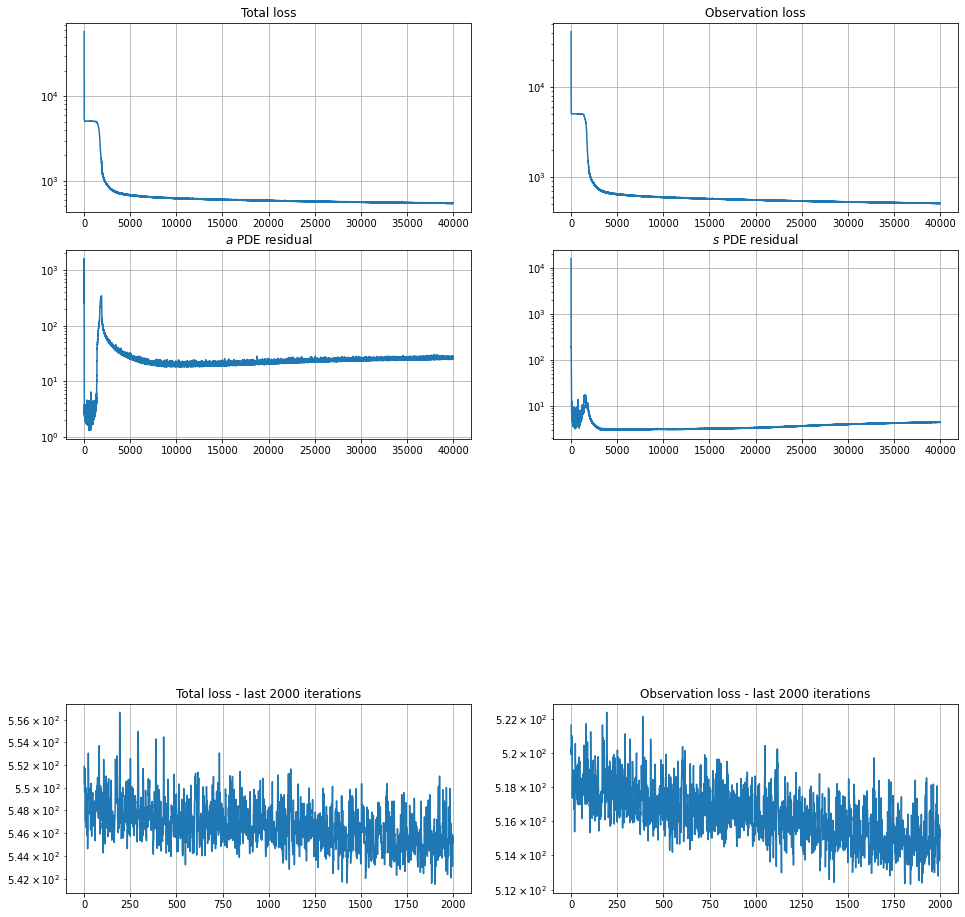

In [93]:
start = 0
end = len(total_loss)
_ = plt.figure(figsize=(16,16))

plt.subplot(4,2,1)
plt.plot(total_loss[start:end])
plt.yscale('log')
plt.title(r"Total loss")
plt.grid()

plt.subplot(4,2,2)
plt.plot(total_loss_obs[start:end])
plt.yscale('log')
plt.title(r"Observation loss")
plt.grid()


plt.subplot(4,2,3)
plt.plot(total_loss_pde_a[start:end])
plt.yscale('log')
plt.title(r"$a$ PDE residual")
plt.grid()

plt.subplot(4,2,4)
plt.plot(total_loss_pde_s[start:end])
plt.yscale('log')
plt.title(r"$s$ PDE residual")
plt.grid()

if model.flg_boundary:
    plt.subplot(4,2,5)
    plt.plot(total_loss_boundary_a[start:end])
    plt.yscale('log')
    plt.title(r"$a$ boundary loss")
    plt.grid()

    plt.subplot(4,2,6)
    plt.plot(total_loss_boundary_s[start:end])
    plt.yscale('log')
    plt.title(r"$s$ boundary loss")
    plt.grid()

plt.subplot(4,2,7)
plt.plot(total_loss[-2000:])
plt.yscale('log')
plt.title(r"Total loss - last 2000 iterations")
plt.grid()

plt.subplot(4,2,8)
plt.plot(total_loss_obs[-2000:])
plt.yscale('log')
plt.title(r"Observation loss - last 2000 iterations")
plt.grid()

plt.show()

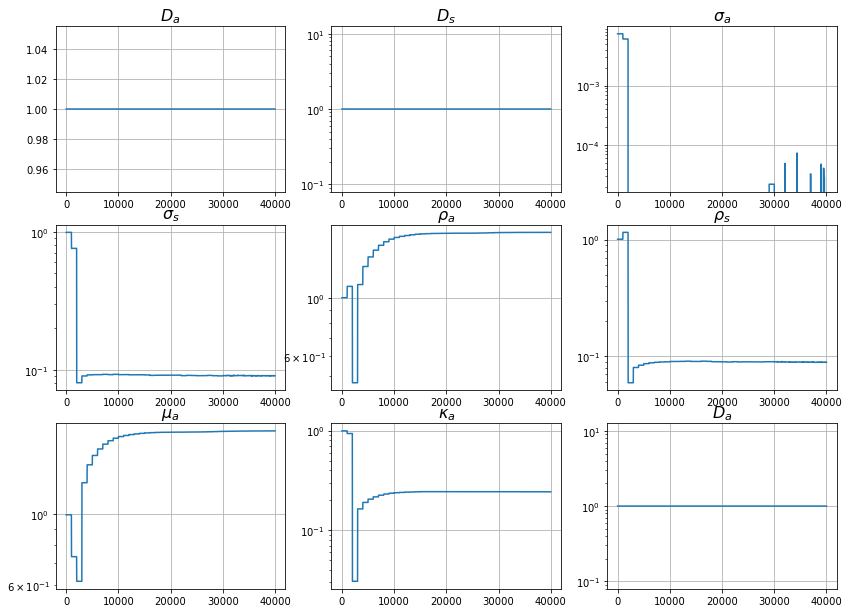

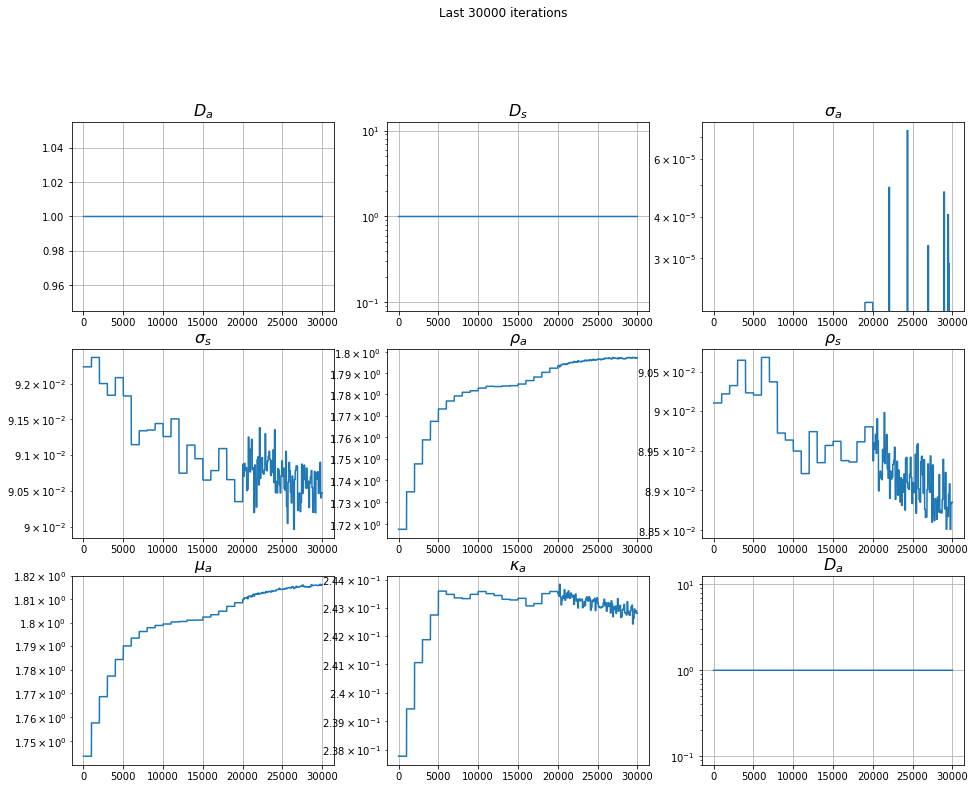

In [97]:
start = 0
end = -1
_ = plt.figure(figsize=(14,14))

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()

start = -30000
end = -1
_ = plt.figure(figsize=(16,16))

plt.suptitle(f"Last {-start} iterations")

plt.subplot(4,3,1)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
#plt.yscale('log')
plt.grid()

plt.subplot(4,3,2)
plt.plot(params_estimates['D_s'][start:end])
plt.title(r"$D_s$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,3)
plt.plot(params_estimates['sigma_a'][start:end])
plt.title(r"$\sigma_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,4)
plt.plot(params_estimates['sigma_s'][start:end])
plt.title(r"$\sigma_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.005,.04])
plt.grid()

plt.subplot(4,3,5)
plt.plot(params_estimates['rho_a'][start:end])
plt.title(r"$\rho_a$", fontsize=16)
plt.yscale('log')
plt.grid()


plt.subplot(4,3,6)
plt.plot(params_estimates['rho_s'][start:end])
plt.title(r"$\rho_s$", fontsize=16)
plt.yscale('log')
#plt.ylim([0.0,.05])
plt.grid()


plt.subplot(4,3,7)
plt.plot(params_estimates['mu_a'][start:end])
plt.title(r"$\mu_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.subplot(4,3,8)
plt.plot(params_estimates['kappa_a'][start:end])
plt.title(r"$\kappa_a$", fontsize=16)
plt.yscale('log')
#plt.ylim([0,1])
plt.grid()

plt.subplot(4,3,9)
plt.plot(params_estimates['D_a'][start:end])
plt.title(r"$D_a$", fontsize=16)
plt.yscale('log')
plt.grid()

plt.show()


# Estimated parameters

In [80]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1#-1
t_test = 50000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [81]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_obs_tf: x_2, model.y_obs_tf: y_2, model.t_obs_tf: t_2, 
           model.a_obs_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_obs_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_pde_tf: model.x_pde, model.y_pde_tf: model.y_pde, model.t_pde_tf: model.t_pde}
if model.flg_boundary:
    tf_dict = {**tf_dict,
               **{model.x_boundary_LB_tf: model.x_boundary_LB, 
                  model.y_boundary_LB_tf: model.y_boundary_LB, 
                  model.t_boundary_LB_tf: model.t_boundary_LB,
                  model.x_boundary_TR_tf: model.x_boundary_TR, 
                  model.y_boundary_TR_tf: model.y_boundary_TR, 
                  model.t_boundary_TR_tf: model.t_boundary_TR}
              }
print( f"Loss_a           : {model.sess.run(model.loss_pde_a, tf_dict):.8f}")
print( f"Loss_s           : {model.sess.run(model.loss_pde_s, tf_dict):.8f}")
print( f"Loss_obs         : {model.sess.run(model.loss_obs, tf_dict):.8f}")
if model.flg_boundary:
    print( f"Loss_boundary_a  : {model.sess.run(model.loss_boundary_a, tf_dict):.8f}")
    print( f"Loss_boundary_s  : {model.sess.run(model.loss_boundary_s, tf_dict):.8f}")
print( f"Loss             : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a           : 24.18018723
Loss_s           : 3.95667982
Loss_obs         : 9.96291637
Loss             : 38.09978485


In [82]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

9.394651068477483
0.5682651071943747


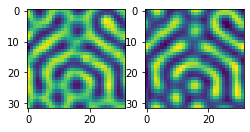

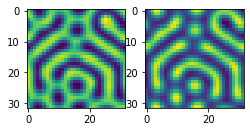

In [83]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [133]:
0.55728072*1.67802799

0.9351326464473527

In [131]:
0.55728072*0.01

0.0055728072

In [132]:
1.67802799*0.005

0.00839013995

In [134]:
10.73470211*0.09197842

0.9873609392484664